# Surface ageostrophic velocity and Ekman dynamics

## Compute geostrophic velocity

In [1]:
import numpy as np
import xarray as xr
import xmitgcm
import xgcm
import glob
from os.path import expanduser,join
import sys
# sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import matplotlib.pyplot as plt

from ecco_po_tutorials import *

# %pip install h5netcdf


In [2]:
grid_params_file = 'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc'
curr_denspress_file = 'OCEAN_DENS_STRAT_PRESS_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc'

ds_dens_mo = xr.open_dataset(curr_denspress_file);
ds_vel_mo = xr.open_dataset('OCEAN_VELOCITY_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc');
ds_grid = xr.open_dataset(grid_params_file);


ds_stress_mo = xr.open_dataset('OCEAN_AND_ICE_SURFACE_STRESS_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc');
oceTAUX = ds_stress_mo.oceTAUX.expand_dims(dim={'k':np.array([0,1])},axis=1)
oceTAUY = ds_stress_mo.oceTAUY.expand_dims(dim={'k':np.array([0,1])},axis=1)

In [3]:
# compute geostrophic velocities for upper 2 layers of output
dict_subset = {'k':[0,1]}
ds_grid = ds_grid.isel({'k':[0,1],'k_l':[0,1],'k_u':[0,1],'k_p1':[0,1,2]})
ds_geos_vel = geos_vel_compute(curr_denspress_file,grid_filename=grid_params_file,fc_filename='na') #,subset=dict_subset)
u_g = ds_geos_vel.u_g
v_g = ds_geos_vel.v_g

ds_vel = ds_vel_mo.isel(dict_subset)

grid = ecco.get_llc_grid(ds_grid)
vel_interp = grid.interp_2d_vector({'X':ds_vel.UVEL,'Y':ds_vel.VVEL})
u_interp = vel_interp['X']
v_interp = vel_interp['Y']

/usr/local/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/usr/local/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/usr/local/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.di

## Ageostrophic velocity orientation

In [4]:
# difference between actual and geostrophic velocity vectors (in complex plane)

u_diff = u_interp - u_g
v_diff = v_interp - v_g
vel_diff_complex = u_diff + (1j*v_diff)    # in Python, imaginary number i is indicated by 1j
vel_complex = u_interp + (1j*v_interp)

# normalize magnitude of difference vector by magnitude of actual velocity
vel_diff_abs = np.abs(vel_diff_complex)
vel_abs = np.abs(vel_complex)
vel_diff_norm = vel_diff_abs/vel_abs

# direction angle of ageostrophic velocity
co = np.expand_dims(ds_grid.CS,axis=(0,1))
si = np.expand_dims(ds_grid.SN,axis=(0,1))
u_east_diff = (co*u_diff) - (si*v_diff)
v_north_diff = (si*u_diff) + (co*v_diff)
vel_diff_complex_axiscorrected = u_east_diff + (1j*v_north_diff)
direction_angle_ageostr = np.imag(np.log(vel_diff_complex_axiscorrected))   # direction angle (0=eastward,pi/2=northward)

# k index (depth level) to plot
k_plot = 1

depth_str = str(int(-ds_grid.Z.isel(k=k_plot)))

# colormap with NaN masking
seismic_nanmasked = plt.get_cmap('seismic').copy()
seismic_nanmasked.set_bad('black')
twilight_nanmasked = plt.get_cmap('twilight').copy()
twilight_nanmasked.set_bad('black')

/usr/local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


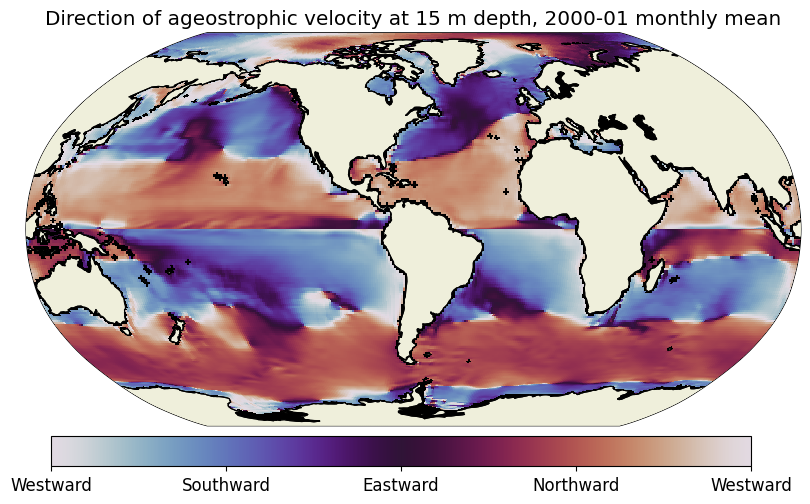

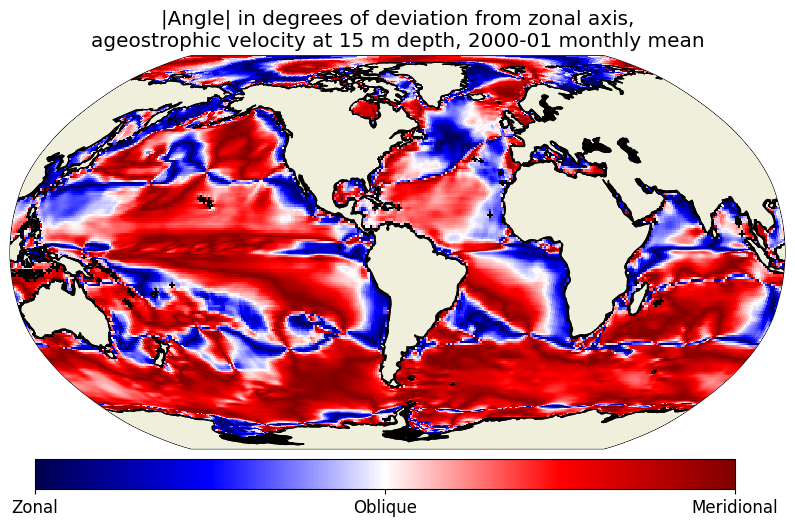

In [5]:
plt.rcParams["font.size"] = 12    # set default font size

time_month_str = str(ds_vel.time.values[0])[:7]


# plot figures

curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        direction_angle_ageostr.isel(k=k_plot).squeeze(),\
                                        cmin=-np.pi,cmax=np.pi,cmap=twilight_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(10)
curr_fig.set_figheight(6)

# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.15,0.1,0.7,0.05])
import matplotlib.colors as colors
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                           norm=colors.Normalize(vmin=-np.pi,vmax=np.pi),\
                           cmap=twilight_nanmasked),cax=cbar_ax,orientation='horizontal')
cbar.set_ticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],\
               labels=['Westward','Southward','Eastward','Northward','Westward'])

# add title
curr_ax.set_title('Direction of ageostrophic velocity at ' + depth_str + ' m depth, '\
                  + time_month_str + ' monthly mean')

plt.savefig('Ageostr_vel_dir_global_' + depth_str + 'm_depth_' + time_month_str + '_monmean.png')
plt.show()



angle_dev_from_zonal = (np.pi/2) - np.abs((direction_angle_ageostr % np.pi) - (np.pi/2))

curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        (180/np.pi)*angle_dev_from_zonal.isel(k=k_plot).squeeze(),\
                                        cmin=0,cmax=90,cmap=seismic_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(10)
curr_fig.set_figheight(6)

# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.15,0.1,0.7,0.05])
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                           norm=colors.Normalize(vmin=0,vmax=90),\
                           cmap=seismic_nanmasked),cax=cbar_ax,orientation='horizontal')
cbar.set_ticks(ticks=[0,45,90],labels=['Zonal','Oblique','Meridional'])

# add title
curr_ax.set_title('|Angle| in degrees of deviation from zonal axis,\n'\
                  + 'ageostrophic velocity at ' + depth_str + ' m depth, '+ time_month_str + ' monthly mean')

plt.savefig('Ageostr_vel_angle_from_zonal_global_' + depth_str + 'm_depth_' + time_month_str + '_monmean.png')
plt.show()

## Near-surface ageostrophic velocity vs. surface stress

In [6]:
direction_angle_ageostr

<xarray.DataArray (time: 1, k: 2, tile: 13, j: 90, i: 90)> Size: 842kB
array([[[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [0.8285856 , 0.83761567, 0.85876584, ..., 0.8544507 ,
           0.8659097 , 0.8806711 ],
          [0.8253035 , 0.8123449 , 0.8172482 , ..., 0.8212518 ,
           0.8313994 , 0.83898574],
          [0.80494356, 0.7774999 , 0.7764072 , ..., 0.7942747 ,
           0.7946311 , 0.7970566 ]],

         [[0.7586851 , 0.7290399 , 0.7490839 , ..., 0.7851769 ,
           0.7797626 , 0.77561235],
          [0.71833396, 0.69250286, 0.7505637 , ..., 0.78721726,
           0.78271323, 0.7719016 ],
          [0.71549594, 0.6714245 , 0.8138863 , ..., 0.78625953,
           0.7836876 , 0.7706422 ],
...
          [2.276003  , 2.3184896 , 2.3786058 , ..., 1.3325145 ,
           1.3205655 , 1.3418467 ],
          [2.288315  , 2.3263812 , 2.380796  , ..., 1.3088505 ,
           1.2889876 , 1.3373628 ],
          [2.2859375 , 2.314918  , 2.3627322 , ..., 1.266242  ,
           1.2490282 , 1.3200519 ]],

         [[1.4366491 , 1.4544194 , 1.470585  , ...,        nan,
                  nan,        nan],
          [1.4262174 , 1.4582182 , 1.4862167 , ...,        nan,
                  nan,        nan],
          [1.4217476 , 1.4694176 , 1.5088655 , ...,        nan,
                  nan,        nan],
          ...,
          [1.3704896 , 1.3613179 , 1.3229882 , ...,        nan,
                  nan,        nan],
          [1.3915837 , 1.3942633 , 1.3578708 , ...,        nan,
                  nan,        nan],
          [1.4025261 , 1.4226753 , 1.3975774 , ...,        nan,
                  nan,        nan]]]]], dtype=float32)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 8B 0 1
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 8B 2000-01-16T12:00:00
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Z        (k) float32 8B -5.0 -15.0

/usr/local/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/usr/local/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


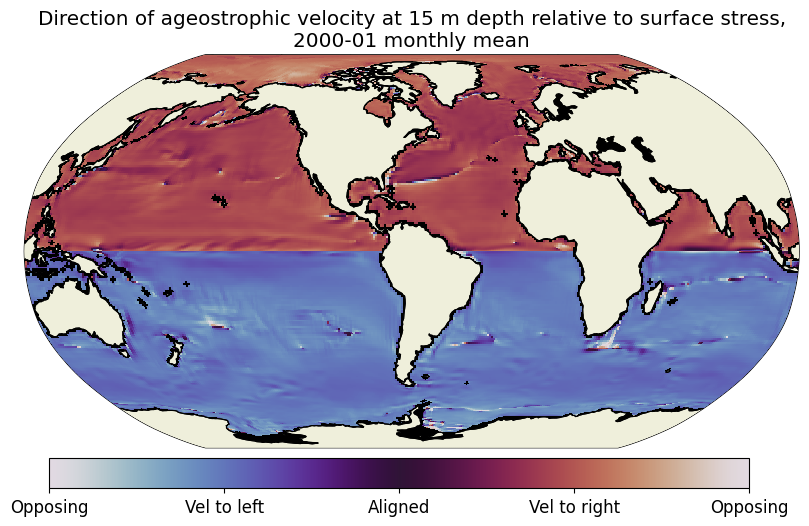

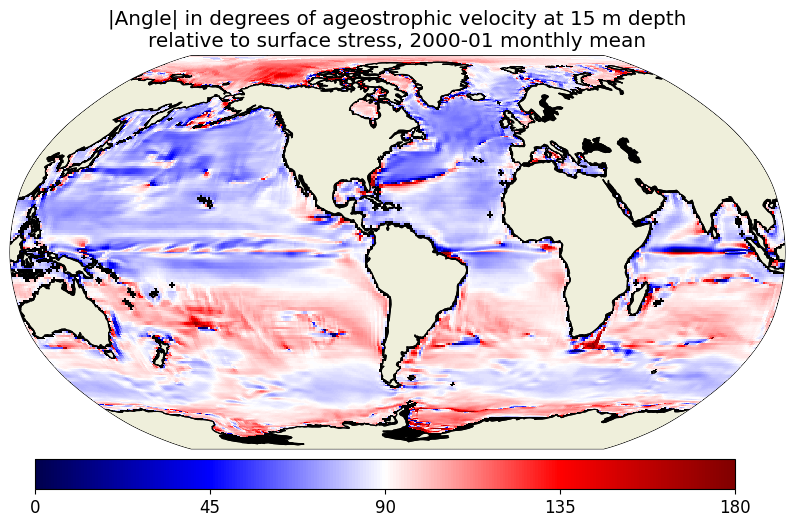

In [7]:
stress_interp = grid.interp_2d_vector({'X':oceTAUX,'Y':oceTAUY})
oceTAUX_interp = stress_interp['X']
oceTAUY_interp = stress_interp['Y']
oceTAUX_interp = oceTAUX_interp.isel(k=[0])
oceTAUY_interp = oceTAUY_interp.isel(k=[0])

oceTAUE = (co*oceTAUX_interp) - (si*oceTAUY_interp)
oceTAUN = (si*oceTAUX_interp) + (co*oceTAUY_interp)

stress_complex = oceTAUE + (1j*oceTAUN)
direction_stress = np.imag(np.log(stress_complex))

# angle difference between ageostrophic velocity and surface stress (positive=velocity to right of stress)
angle_vel_minus_stress = (((-(direction_angle_ageostr - np.tile(direction_stress,(1,len(ds_grid.k),1,1,1))))\
                           + np.pi) % (2*np.pi)) - np.pi



# plot figures

curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        angle_vel_minus_stress.isel(k=k_plot).squeeze(),\
                                        cmin=-np.pi,cmax=np.pi,cmap=twilight_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(10)
curr_fig.set_figheight(6)

# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.15,0.1,0.7,0.05])
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                           norm=colors.Normalize(vmin=-np.pi,vmax=np.pi),\
                           cmap=twilight_nanmasked),cax=cbar_ax,orientation='horizontal')
cbar.set_ticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],\
               labels=['Opposing','Vel to left','Aligned','Vel to right','Opposing'])

# add title
curr_ax.set_title('Direction of ageostrophic velocity at ' + depth_str + ' m depth relative to surface stress,\n'\
                  + time_month_str + ' monthly mean')

plt.savefig('Ageostr_vel_dir_from_stress_global_' + depth_str + 'm_depth_' + time_month_str + '_monmean.png')
plt.show()



curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        (180/np.pi)*np.abs(angle_vel_minus_stress).isel(k=k_plot).squeeze(),\
                                        cmin=0,cmax=180,cmap=seismic_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(10)
curr_fig.set_figheight(6)

# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.15,0.1,0.7,0.05])
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                           norm=colors.Normalize(vmin=0,vmax=180),\
                           cmap=seismic_nanmasked),cax=cbar_ax,orientation='horizontal')
cbar.set_ticks(ticks=[0,45,90,135,180])

# add title
curr_ax.set_title('|Angle| in degrees of ageostrophic velocity at ' + depth_str + ' m depth\n'
                  'relative to surface stress, ' + time_month_str + ' monthly mean')

plt.savefig('Ageostr_vel_angle_from_stress_global_' + depth_str + 'm_depth_' + time_month_str + '_monmean.png')
plt.show()